In [4]:
# -*- coding: utf-8 -*-
"""
TLA Corpus Analysis: Геополитические взаимодействия Египта
=========================================================

Анализ текстов Thesaurus Linguae Aegyptiae для изучения геополитических
терминов и их эволюции в древнеегипетских источниках.

Данный notebook демонстрирует методы извлечения и анализа:
- Топонимов (TOPN): географические названия, важные для понимания
  внешнеполитических связей
- Титулов (TITL): должности и звания, отражающие административную структуру
- Царских имен (ROYLN): правители и их упоминания в контексте дипломатии

Корпус: TLA Earlier v18 и TLA Late v19
https://huggingface.co/datasets/thesaurus-linguae-aegyptiae/tla-Earlier_Egyptian_original-v18-premium
https://huggingface.co/datasets/thesaurus-linguae-aegyptiae/tla-late_egyptian-v19-premium
"""

import json
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Set, Tuple

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [5]:

# =============================================================================
# 1. ИНИЦИАЛИЗАЦИЯ И БАЗОВЫЙ АНАЛИЗ ГРАММАТИЧЕСКИХ КАТЕГОРИЙ
# =============================================================================

FILES = [Path('TLA Earlier v18.jsonl'), Path('TLA Late v19.jsonl')]

def create_upos_gloss_mapping(files: List[Path]) -> Dict[str, List[str]]:
    """
    Создание карты соответствий UPOS (Universal POS tags) -> Glossing tags

    Важно для понимания грамматической структуры египетских текстов
    и выделения семантических категорий (топонимы, титулы, имена правителей).
    """
    upos_gloss_map = {}

    for fp in files:
        print(f"Обрабатываем: {fp.name}")
        with open(fp, encoding='utf-8') as f:
            for line in f:
                obj = json.loads(line)
                upos = obj['UPOS'].split()
                gloss = obj['glossing'].split()

                for u, g in zip(upos, gloss):
                    upos_gloss_map.setdefault(u, set()).add(g)

    # Преобразуем множества в отсортированные списки
    result = {u: sorted(list(gs)) for u, gs in upos_gloss_map.items()}

    # Создаём DataFrame для анализа
    df = pd.DataFrame([
        {'UPOS': u, 'Glossings': ', '.join(gs), 'Count': len(gs)}
        for u, gs in result.items()
    ])

    print("Распределение грамматических категорий:")
    print(df.sort_values('Count', ascending=False))

    return result

# Выполняем базовый анализ
upos_mapping = create_upos_gloss_mapping(FILES)

Обрабатываем: TLA Earlier v18.jsonl
Обрабатываем: TLA Late v19.jsonl
Распределение грамматических категорий:
     UPOS                                          Glossings  Count
0    VERB  (undefined), ADJ-excl, ADJ:f.sg, ADJ:m.pl, ADJ...    116
2    PRON  -1pl, -1sg, -2du, -2pl, -2sg.f, -2sg.m, -3du, ...     66
6     ADJ  ADJ, ADJ(problematic), ADJ-excl, ADJ:f.du, ADJ...     42
4    NOUN  (undefined), ADJ:f.sg, DIVN, N, N.f, N.f:du, N...     40
5   PROPN  (undefined), ADJ:m.sg, DIVN, N:du, N:pl, N:pl:...     14
3    PART  =PTCL, AUX, AUX:stpr, PREP:stpr, PRON.rel:stpr...     12
9     NUM  N:pl, N:sg:stpr, NUM, NUM.card, NUM.card:f, NU...      8
1     ADP  ADJ:f.pl:stpr, ADJ:m.pl, ADJ:m.sg, N:sg:stpr, ...      7
7     ADV                          ADV, PREP:stpr, PREP\advz      3
8    INTJ                                               INTJ      1
10  PUNCT                                        (undefined)      1


In [6]:

# =============================================================================
# 2. ВРЕМЕННОЙ АНАЛИЗ ГЕОПОЛИТИЧЕСКИХ КАТЕГОРИЙ
# =============================================================================

def analyze_geopolitical_categories_over_time(files: List[Path],
                                            categories: List[str] = None) -> pd.DataFrame:
    """
    Анализ распределения геополитических категорий по времени.

    Категории по умолчанию:
    - ROYLN: царские имена (важно для дипломатических контактов)
    - TITL: титулы и должности (административная структура)
    - TOPN: топонимы (географический охват влияния)
    """
    if categories is None:
        categories = ["ROYLN", "TITL", "TOPN"]

    # Инициализация структур данных
    lemmas_by_cat = {cat: set() for cat in categories}
    occurrences = {cat: [] for cat in categories}

    # Обработка файлов
    for fname in files:
        period = "Earlier" if "Earlier" in fname.name else "Late"
        print(f"Анализируем период: {period}")

        with open(fname, encoding='utf-8') as f:
            for line in f:
                obj = json.loads(line)
                lemmalist = obj['lemmatization'].split()
                glosslist = obj['glossing'].split()
                date_from = int(obj['dateNotBefore'])
                date_to = int(obj['dateNotAfter'])

                for i, gloss in enumerate(glosslist):
                    if gloss in categories and i < len(lemmalist):
                        lemma = lemmalist[i]
                        lemmas_by_cat[gloss].add(lemma)
                        occurrences[gloss].append({
                            'lemma': lemma,
                            'lemma_id': lemma.split('|')[0] if '|' in lemma else lemma,
                            'lemma_text': lemma.split('|')[1] if '|' in lemma else lemma,
                            'date_from': date_from,
                            'date_to': date_to,
                            'period': period
                        })

    # Сохранение лемм по категориям
    lemmas_serializable = {k: sorted(list(v)) for k, v in lemmas_by_cat.items()}
    with open('geopolitical_lemmas.json', 'w', encoding='utf-8') as f:
        json.dump(lemmas_serializable, f, ensure_ascii=False, indent=2)

    # Временное распределение
    all_dates = []
    for cat, occs in occurrences.items():
        for o in occs:
            all_dates.extend([o['date_from'], o['date_to']])

    min_year, max_year = min(all_dates), max(all_dates)
    segments = np.linspace(min_year, max_year, 6, dtype=int)
    segment_labels = [f"{segments[i]}..{segments[i+1]}" for i in range(5)]

    # Подсчет по сегментам
    result = {cat: [0]*5 for cat in categories}
    for cat, occs in occurrences.items():
        for o in occs:
            mid_date = (o['date_from'] + o['date_to']) // 2
            for i in range(5):
                if segments[i] <= mid_date < segments[i+1]:
                    result[cat][i] += 1
                    break

    df_time = pd.DataFrame(result, index=segment_labels)
    print("\nВременное распределение геополитических категорий:")
    print(df_time)

    # Вывод статистики по уникальным леммам в каждой категории
    print("\nСтатистика по уникальным леммам в категориях:")
    for cat in categories:
        print(f"Категория {cat}: {len(lemmas_by_cat[cat])} уникальных лемм")

    return df_time, occurrences, lemmas_by_cat

# Выполняем временной анализ
time_dist, all_occurrences, lemma_sets = analyze_geopolitical_categories_over_time(FILES)

Анализируем период: Earlier
Анализируем период: Late

Временное распределение геополитических категорий:
              ROYLN  TITL  TOPN
-3350..-2747   1471   166   216
-2747..-2143   1837  2991   325
-2143..-1540     79   405   133
-1540..-936      34   142   166
-936..-332        2     4    13

Статистика по уникальным леммам в категориях:
Категория ROYLN: 96 уникальных лемм
Категория TITL: 619 уникальных лемм
Категория TOPN: 210 уникальных лемм


In [7]:
# Выгрузка списка уникальных лемм категории TOPN
with open('unique_topn_lemmas.txt', 'w', encoding='utf-8') as f:
    for lemma in sorted(lemma_sets['TOPN']):
        f.write(lemma + '\n')
print(f"Сохранено {len(lemma_sets['TOPN'])} уникальных лемм TOPN в unique_topn_lemmas.txt")


Сохранено 210 уникальных лемм TOPN в unique_topn_lemmas.txt



Наиболее частотные леммы в категории TOPN:
(Топонимы - географические объекты):
   Lemma  Frequency       Periods  Temporal_Span  Avg_per_Period
   Šmꜥ.w         93 Earlier, Late           2210            46.5
    Mḥ.w         84 Earlier, Late           2210            42.0
Ḥw.t-nbw         55       Earlier            150            55.0
   Ꞽwn.w         48 Earlier, Late           1550            24.0
   Wꜣḏ.w         28       Earlier             44            28.0
   Ꜣbḏ.w         24 Earlier, Late           1244            12.0
     Ꜣbw         18 Earlier, Late           2273             9.0
   Tꜣ-wr         17 Earlier, Late           1410             8.5
   Tꜣ.wꞽ         17 Earlier, Late           1663             8.5
    Km.t         17 Earlier, Late           1227             8.5
      Pꞽ         16       Earlier           1520            16.0
    Ḏd.w         12 Earlier, Late           1298             6.0
   Km-wr         10       Earlier            585            10.0
Rʾ-sṯꜣ.w 

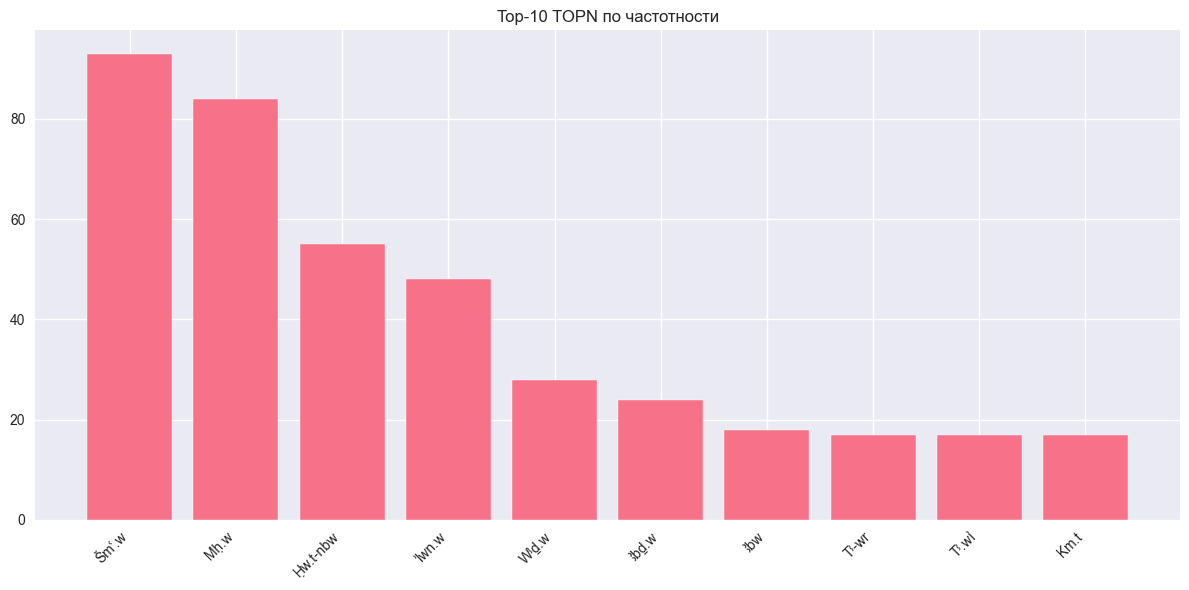


Наиболее частотные леммы в категории TITL:
(Титулы - должности):
           Lemma  Frequency       Periods  Temporal_Span  Avg_per_Period
            Wsꞽr        259       Earlier            191           259.0
  ꞽr.ꞽ-ꞽḫ.t-nswt        172       Earlier           1056           172.0
           ḥm-kꜣ        120       Earlier            943           120.0
       smr-wꜥ.tꞽ        110       Earlier            776           110.0
 ꞽr.ꞽt-ꞽḫ.t-nswt        109       Earlier            619           109.0
           zẖꜣ.w         93 Earlier, Late           2540            46.5
      ẖr.ꞽ-ḥꜣb.t         81       Earlier           1520            81.0
         ḥꜣ.tꞽ-ꜥ         69 Earlier, Late           1495            34.5
        wꜥb-nswt         65       Earlier            706            65.0
         nb.t-pr         60       Earlier            350            60.0
ꞽmꜣḫ.w-ḫr-nṯr-ꜥꜣ         59       Earlier            706            59.0
      ꞽm.ꞽ-rʾ-pr         47 Earlier, Late           1575  

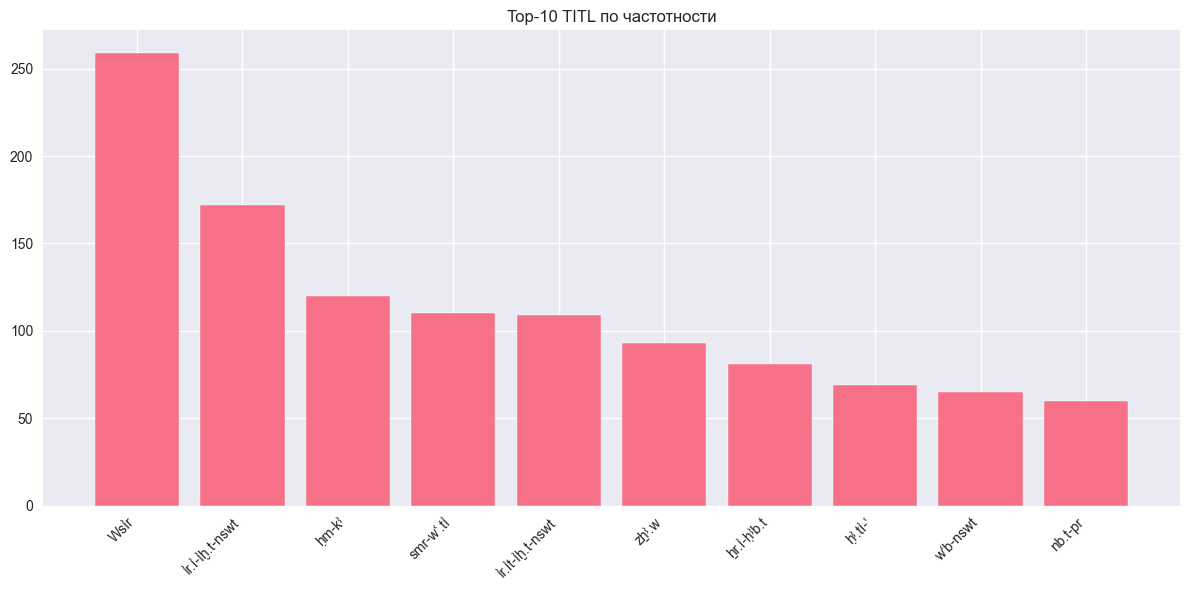


Наиболее частотные леммы в категории ROYLN:
(Царские имена):
       Lemma  Frequency       Periods  Temporal_Span  Avg_per_Period
        Ḥr.w        812 Earlier, Late           2147           406.0
        Wnꞽs        644       Earlier             52           644.0
         Ppy        333       Earlier            137           333.0
  Nfr-kꜣ-Rꜥw        240       Earlier             94           240.0
         Ꜥḥꜣ        235       Earlier            350           235.0
         Ttꞽ        151       Earlier            313           151.0
          Dn        116       Earlier            174           116.0
Nmt.ꞽ-m-zꜣ=f         97       Earlier              9            97.0
    Mr.n-Rꜥw         97       Earlier              9            97.0
          Ḏr         90       Earlier            262            90.0
        Qꜣ-ꜥ         73       Earlier             86            73.0
  nswt-bꞽ.tꞽ         72 Earlier, Late           2019            36.0
   Nṯr.ꞽ-ẖ.t         64       Earlier    

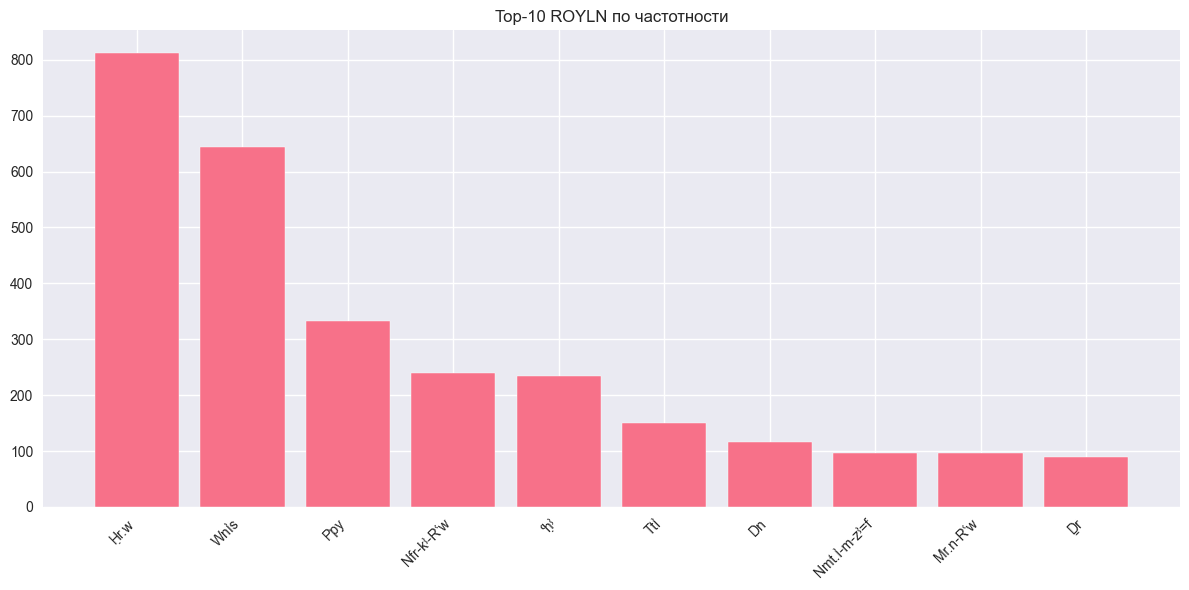

In [4]:

# =============================================================================
# 2.2. АНАЛИЗ ЧАСТОТНОСТИ ЛЕММ В КАТЕГОРИЯХ
# =============================================================================

def get_most_frequent_lemmas(occurrences: Dict, category: str, top_n: int = 20) -> pd.DataFrame:
    """
    Выделение наиболее частотных лемм в заданной категории.

    Для геополитического анализа особенно важны:
    - TOPN: наиболее упоминаемые регионы и города (торговые/военные связи)
    - TITL: ключевые должности в дипломатии и администрации
    - ROYLN: наиболее значимые правители в международных отношениях
    """
    if category not in occurrences:
        print(f"Категория {category} не найдена")
        return pd.DataFrame()

    # Подсчет частотности лемм
    lemma_counter = Counter()
    lemma_details = defaultdict(lambda: {
        'periods': set(),
        'date_ranges': [],
        'total_span': 0
    })

    for occ in occurrences[category]:
        lemma_text = occ['lemma_text']
        lemma_counter[lemma_text] += 1

        lemma_details[lemma_text]['periods'].add(occ['period'])
        lemma_details[lemma_text]['date_ranges'].append((occ['date_from'], occ['date_to']))

    # Расчет временного охвата для каждой леммы
    for lemma, details in lemma_details.items():
        dates = [date for range_dates in details['date_ranges'] for date in range_dates]
        details['total_span'] = max(dates) - min(dates) if dates else 0
        details['periods'] = ', '.join(sorted(details['periods']))

    # Создание DataFrame
    freq_data = []
    for lemma, count in lemma_counter.most_common(top_n):
        details = lemma_details[lemma]
        freq_data.append({
            'Lemma': lemma,
            'Frequency': count,
            'Periods': details['periods'],
            'Temporal_Span': details['total_span'],
            'Avg_per_Period': round(count / len(details['periods'].split(', ')), 2)
        })

    df_freq = pd.DataFrame(freq_data)

    print(f"\nНаиболее частотные леммы в категории {category}:")
    print(f"({'Топонимы - географические объекты' if category == 'TOPN' else 'Титулы - должности' if category == 'TITL' else 'Царские имена'}):")
    print(df_freq.to_string(index=False))

    return df_freq

# Анализ частотности для каждой категории
for category in ["TOPN", "TITL", "ROYLN"]:
    freq_df = get_most_frequent_lemmas(all_occurrences, category, top_n=15)

    # Визуализация
    if not freq_df.empty:
        plt.figure(figsize=(12, 6))
        plt.bar(freq_df['Lemma'][:10], freq_df['Frequency'][:10])
        plt.title(f'Top-10 {category} по частотности')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [5]:

# =============================================================================
# 2.3. АНАЛИЗ СОЧЕТАНИЙ ГЕОПОЛИТИЧЕСКИХ КАТЕГОРИЙ
# =============================================================================

def find_cooccurrences_in_texts(files: List[Path],
                               category_pairs: List[Tuple[str, str]] = None) -> Dict:
    """
    Поиск совместных упоминаний геополитических категорий в одном тексте.

    Анализирует:
    - TOPN + TITL: связь географических регионов с административными должностями
    - TOPN + ROYLN: упоминание правителей в контексте внешних территорий
    - TITL + ROYLN: должности при конкретных правителях

    Критично для понимания:
    - Дипломатических миссий
    - Территориальной администрации
    - Международных династических связей
    """
    if category_pairs is None:
        category_pairs = [("TOPN", "TITL"), ("TOPN", "ROYLN"), ("TITL", "ROYLN")]

    cooccurrence_data = {f"{cat1}+{cat2}": [] for cat1, cat2 in category_pairs}

    for fname in files:
        period = "Earlier" if "Earlier" in fname.name else "Late"

        with open(fname, encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                obj = json.loads(line)
                glosslist = obj['glossing'].split()
                lemmalist = obj['lemmatization'].split()

                # Находим все категории в данном тексте
                categories_in_text = defaultdict(list)
                for i, gloss in enumerate(glosslist):
                    if i < len(lemmalist):
                        lemma_text = lemmalist[i].split('|')[1] if '|' in lemmalist[i] else lemmalist[i]
                        categories_in_text[gloss].append({
                            'lemma': lemma_text,
                            'position': i
                        })

                # Проверяем наличие пар категорий
                for cat1, cat2 in category_pairs:
                    if cat1 in categories_in_text and cat2 in categories_in_text:
                        # Все возможные комбинации лемм из двух категорий
                        for item1 in categories_in_text[cat1]:
                            for item2 in categories_in_text[cat2]:
                                cooccurrence_data[f"{cat1}+{cat2}"].append({
                                    'text_id': line_num,
                                    'period': period,
                                    f'{cat1.lower()}_lemma': item1['lemma'],
                                    f'{cat2.lower()}_lemma': item2['lemma'],
                                    'distance': abs(item1['position'] - item2['position']),
                                    'translation': obj.get('translation', ''),
                                    'date_from': int(obj['dateNotBefore']),
                                    'date_to': int(obj['dateNotAfter']),
                                    'hieroglyphs': obj.get('hieroglyphs', ''),
                                    'transliteration': obj.get('transliteration', '')
                                })

    # Анализ результатов
    results = {}
    for pair_name, cooccs in cooccurrence_data.items():
        if cooccs:
            df_cooc = pd.DataFrame(cooccs)

            print(f"\n{'='*50}")
            print(f"СОЧЕТАНИЯ {pair_name}")
            print(f"{'='*50}")
            print(f"Всего найдено сочетаний: {len(cooccs)}")

            # Наиболее частые пары
            if pair_name == "TOPN+TITL":
                pair_counts = df_cooc.groupby(['topn_lemma', 'titl_lemma']).size().reset_index(name='count')
                print("\nНаиболее частые пары ТОПОНИМ + ТИТУЛ:")
                print("(Связь географии с административными должностями)")

            elif pair_name == "TOPN+ROYLN":
                pair_counts = df_cooc.groupby(['topn_lemma', 'royln_lemma']).size().reset_index(name='count')
                print("\nНаиболее частые пары ТОПОНИМ + ЦАРСКОЕ ИМЯ:")
                print("(Географический контекст правления)")

            elif pair_name == "TITL+ROYLN":
                pair_counts = df_cooc.groupby(['titl_lemma', 'royln_lemma']).size().reset_index(name='count')
                print("\nНаиболее частые пары ТИТУЛ + ЦАРСКОЕ ИМЯ:")
                print("(Должности при конкретных правителях)")

            top_pairs = pair_counts.sort_values('count', ascending=False).head(10)
            print(top_pairs.to_string(index=False))

            # Примеры контекстов
            print(f"\nПримеры контекстов (ближайшие по расстоянию):")
            closest_examples = df_cooc.nsmallest(3, 'distance')[
                ['topn_lemma' if 'topn_lemma' in df_cooc.columns else 'titl_lemma',
                 'titl_lemma' if 'titl_lemma' in df_cooc.columns else 'royln_lemma',
                 'distance', 'translation', 'period']
            ]
            for _, row in closest_examples.iterrows():
                print(f"- Расстояние: {row['distance']} | Период: {row['period']}")
                print(f"  Перевод: {row['translation'][:100]}...")
                print()

            results[pair_name] = {
                'dataframe': df_cooc,
                'top_pairs': top_pairs,
                'total_cooccurrences': len(cooccs)
            }
        else:
            print(f"\nСочетания {pair_name} не найдены")
            results[pair_name] = {'dataframe': pd.DataFrame(), 'total_cooccurrences': 0}

    return results

# Выполняем анализ сочетаний
cooccurrence_results = find_cooccurrences_in_texts(FILES)


СОЧЕТАНИЯ TOPN+TITL
Всего найдено сочетаний: 167

Наиболее частые пары ТОПОНИМ + ТИТУЛ:
(Связь географии с административными должностями)
topn_lemma     titl_lemma  count
     Tꜣ-wr  ḥqꜣ-ḥw.t-ꜥꜣ.t      5
     Wꜣḏ.t ꞽm.ꞽ-rʾ-wpw.wt      5
     Wꜣḏ.t  ḥqꜣ-ḥw.t-ꜥꜣ.t      5
     Wꜣḏ.t ꞽm.ꞽ-rʾ-mnn.ww      5
     Tꜣ-wr ꞽm.ꞽ-rʾ-wpw.wt      5
     Tꜣ-wr ꞽm.ꞽ-rʾ-sw.tꞽw      5
     Wꜣḏ.t ꞽm.ꞽ-rʾ-sw.tꞽw      5
     Tꜣ-wr ꞽm.ꞽ-rʾ-mnn.ww      5
     Tꜣ-wr       sšm.w-tꜣ      5
     Wꜣḏ.t       sšm.w-tꜣ      5

Примеры контекстов (ближайшие по расстоянию):
- Расстояние: 1 | Период: Earlier
  Перевод: Die den Horus sieht, die Prinzessin Hetep-her-nebti....

- Расстояние: 1 | Период: Earlier
  Перевод: Thinitischer Gau (8. o.äg. Gau): Vorsteher der Festungen, Aufseher der Königsleute, Vorsteher der Au...

- Расстояние: 1 | Период: Earlier
  Перевод: Thinitischer Gau (8. o.äg. Gau): Vorsteher der Festungen, Aufseher der Königsleute, Vorsteher der Au...


СОЧЕТАНИЯ TOPN+ROYLN
Всего найдено сочетаний: 12


Наиболее частотные леммы в категории TOPN:
(Топонимы - географические объекты):
   Lemma  Frequency       Periods  Temporal_Span  Avg_per_Period
   Šmꜥ.w         93 Earlier, Late           2210            46.5
    Mḥ.w         84 Earlier, Late           2210            42.0
Ḥw.t-nbw         55       Earlier            150            55.0
   Ꞽwn.w         48 Earlier, Late           1550            24.0
   Wꜣḏ.w         28       Earlier             44            28.0
   Ꜣbḏ.w         24 Earlier, Late           1244            12.0
     Ꜣbw         18 Earlier, Late           2273             9.0
   Tꜣ-wr         17 Earlier, Late           1410             8.5

Наиболее частотные леммы в категории TITL:
(Титулы - должности):
          Lemma  Frequency       Periods  Temporal_Span  Avg_per_Period
           Wsꞽr        259       Earlier            191           259.0
 ꞽr.ꞽ-ꞽḫ.t-nswt        172       Earlier           1056           172.0
          ḥm-kꜣ        120       Earlier            

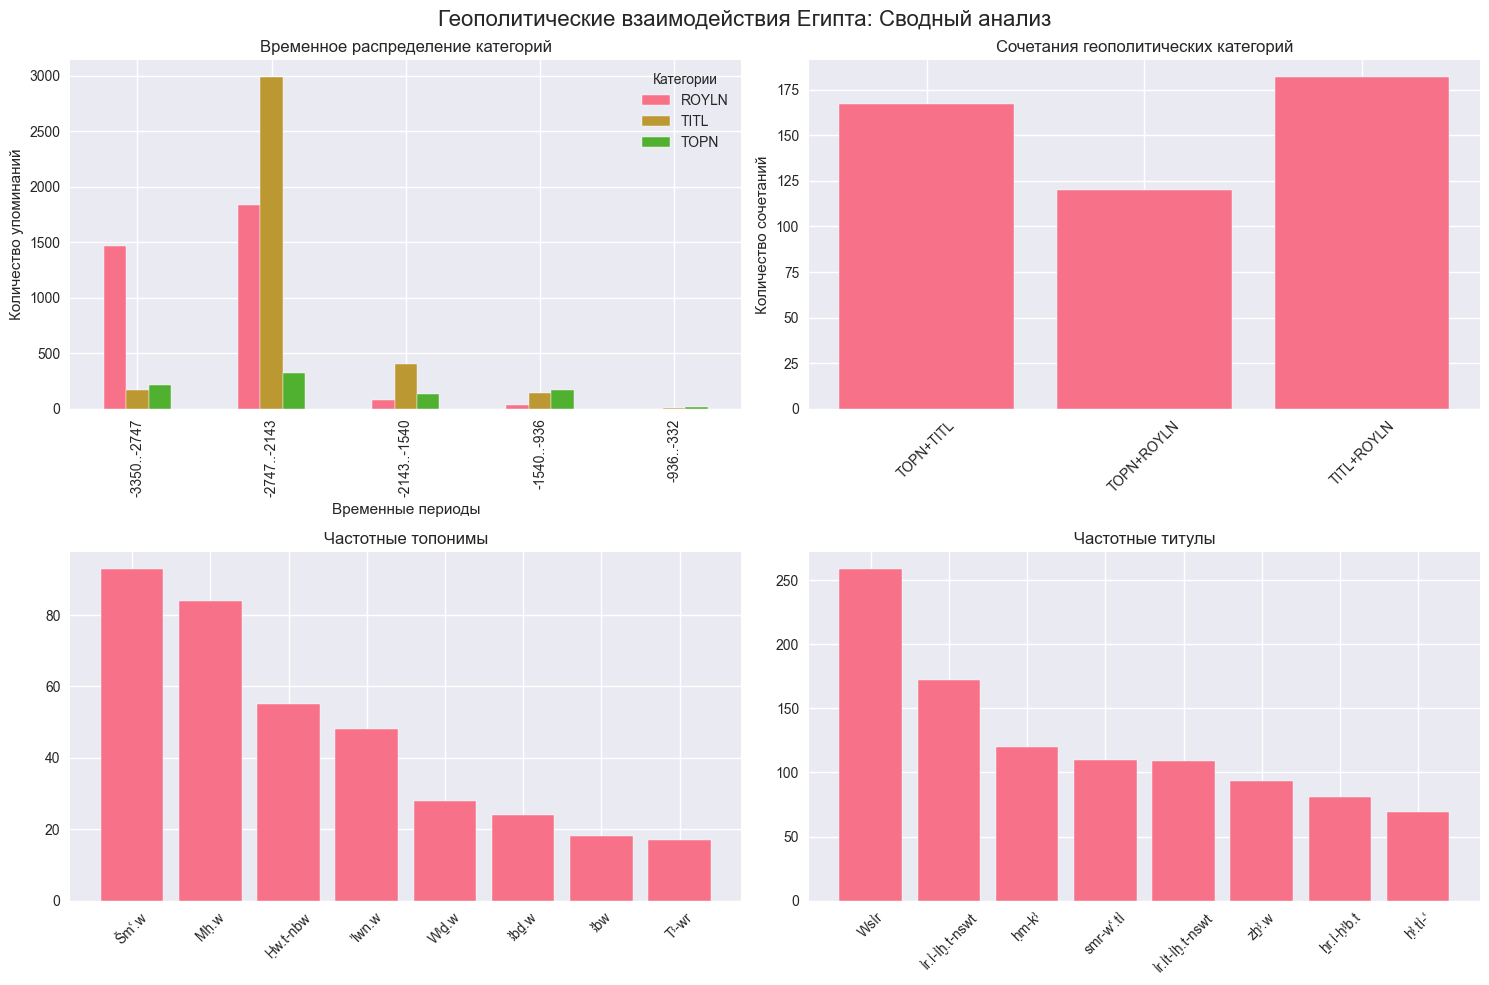

In [6]:

# =============================================================================
# 3. СВОДНЫЙ АНАЛИЗ И ВИЗУАЛИЗАЦИЯ
# =============================================================================

def create_summary_dashboard():
    """
    Создание сводной панели для геополитического анализа
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Геополитические взаимодействия Египта: Сводный анализ', fontsize=16)

    # 1. Временное распределение категорий
    time_dist.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Временное распределение категорий')
    axes[0,0].set_xlabel('Временные периоды')
    axes[0,0].set_ylabel('Количество упоминаний')
    axes[0,0].legend(title='Категории')

    # 2. Сочетания категорий
    cooc_counts = [cooccurrence_results[pair]['total_cooccurrences']
                   for pair in cooccurrence_results.keys()]
    pair_names = list(cooccurrence_results.keys())

    axes[0,1].bar(pair_names, cooc_counts)
    axes[0,1].set_title('Сочетания геополитических категорий')
    axes[0,1].set_ylabel('Количество сочетаний')
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3-4. Частотность топонимов и титулов
    if 'TOPN' in all_occurrences:
        topn_freq = get_most_frequent_lemmas(all_occurrences, 'TOPN', 8)
        if not topn_freq.empty:
            axes[1,0].bar(topn_freq['Lemma'], topn_freq['Frequency'])
            axes[1,0].set_title('Частотные топонимы')
            axes[1,0].tick_params(axis='x', rotation=45)

    if 'TITL' in all_occurrences:
        titl_freq = get_most_frequent_lemmas(all_occurrences, 'TITL', 8)
        if not titl_freq.empty:
            axes[1,1].bar(titl_freq['Lemma'], titl_freq['Frequency'])
            axes[1,1].set_title('Частотные титулы')
            axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

create_summary_dashboard()

In [ ]:

# =============================================================================
# 4. ЭКСПОРТ РЕЗУЛЬТАТОВ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА
# =============================================================================

def export_results():
    """
    Экспорт всех результатов для дальнейшего использования в исследовании
    """
    # Временное распределение
    time_dist.to_csv('temporal_distribution.csv', encoding='utf-8')

    # Частотные леммы по категориям
    for category in ["TOPN", "TITL", "ROYLN"]:
        if category in all_occurrences:
            freq_df = get_most_frequent_lemmas(all_occurrences, category, 50)
            freq_df.to_csv(f'frequent_{category.lower()}.csv', encoding='utf-8', index=False)

    # Сочетания
    for pair_name, data in cooccurrence_results.items():
        if not data['dataframe'].empty:
            data['dataframe'].to_csv(f'cooccurrences_{pair_name.lower()}.csv',
                                   encoding='utf-8', index=False)

    print("Результаты экспортированы в CSV файлы для дальнейшего анализа")

export_results()